# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from sklearn import preprocessing as pp
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [6]:
from matplotlib import pyplot as plt


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    #display(HTML('<style>.container {width:100% !important; }</style>'))
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows    = None
    #pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat) 
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

In [7]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [8]:
df_bra_raw = pd.read_csv('datasets/bra.csv', header=0)
df_bra_raw.head()

#https://www.youtube.com/watch?v=pC4J41_Dxn0

,Data,Hora (UTC),Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Max. (%),Umi. Min. (%),Pto Orvalho Ins. (C),Pto Orvalho Max. (C),...,Pressao Ins. (hPa),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Radiacao (KJ/m²),Chuva (mm),Hora Local,Data Ajustada
0,08/11/2022,300,13.2,13.4,13.2,89.0,89.0,87.0,11.4,11.5,...,917.9,918.4,917.9,1.8,245.0,6.9,NaN,0.0,0,08/11/2022
1,08/11/2022,400,13.1,13.3,13.1,86.0,89.0,86.0,10.9,11.5,...,917.3,917.9,917.3,3.1,247.0,6.1,NaN,0.0,1,08/11/2022
2,08/11/2022,500,12.5,13.1,12.5,91.0,91.0,86.0,11.1,11.1,...,916.5,917.3,916.5,2.4,257.0,5.8,NaN,0.0,2,08/11/2022
3,08/11/2022,600,12.2,12.5,12.2,92.0,92.0,91.0,11.0,11.1,...,916.1,916.5,916.1,2.8,254.0,5.8,NaN,0.0,3,08/11/2022
4,08/11/2022,700,11.8,12.2,11.7,94.0,95.0,92.0,10.8,11.0,...,916.1,916.2,916.0,2.0,246.0,5.3,NaN,0.0,4,08/11/2022


In [9]:
df_41_raw = pd.read_csv('datasets/41/1.csv')
for i in range(2,20):
    df_41_raw = pd.concat([df_41_raw,pd.read_csv('datasets/41/'+ str(i) +'.csv')])
df_41_raw.shape

(22151, 33)

In [10]:
df_42_raw = pd.read_csv('datasets/42/1.csv')
for i in range(2,20):
    df_42_raw = pd.concat([df_42_raw,pd.read_csv('datasets/42/'+ str(i) +'.csv')])
df_42_raw.shape

(21510, 33)

In [11]:
df_44_raw = pd.read_csv('datasets/44/1.csv')
for i in range(2,20):
    df_44_raw = pd.concat([df_44_raw,pd.read_csv('datasets/44/'+ str(i) +'.csv')])
df_44_raw.shape

(21853, 33)

In [12]:
df_44_raw.head()

,Time,InverterSN,Data LoggerSN,Alert Details,Alert Code,DC Voltage PV1(V),DC Voltage PV2(V),DC Voltage PV3(V),DC Voltage PV4(V),DC Current1(A),...,AC Output Frequency R(Hz),Generation of Last Month (Active)(kWh),Daily Generation (Active)(kWh),Total Generation (Active)(kWh),Power Grid Total Apparent Power(VA),Grid Power Factor,Inverter Temperature(℃),Inverter Status,Generation Yesterday(kWh),System Time
0,2022/11/08 04:15,054B7020C020044,4045086367,NaN,NaN,125.2,127.6,108.3,13.5,0.1,...,59.98,1382,0.0,16841.0,90,1.0,21.2,1022,54.8,22-11-8 4:15:9
1,2022/11/08 04:20,054B7020C020044,4045086367,NaN,NaN,295.3,295.2,295.9,16.1,0.1,...,60.00,1382,0.1,16842.0,60,1.0,21.6,1022,54.8,22-11-8 4:20:12
2,2022/11/08 04:20,054B7020C020044,4045086367,NaN,NaN,295.3,295.2,295.9,16.1,0.1,...,60.00,1382,0.1,16842.0,60,1.0,21.6,1022,54.8,22-11-8 4:20:12
3,2022/11/08 04:25,054B7020C020044,4045086367,NaN,NaN,385.7,385.2,385.2,10.8,0.1,...,59.99,1382,0.1,16842.0,140,1.0,22.0,1022,54.8,22-11-8 4:25:15
4,2022/11/08 04:25,054B7020C020044,4045086367,NaN,NaN,385.7,385.2,385.2,10.8,0.1,...,59.99,1382,0.1,16842.0,140,1.0,22.0,1022,54.8,22-11-8 4:25:15


# 1.0 DATA DESCRIPTION

In [13]:
columns = ['Temp. Ins. (C)', 'Umi. Ins. (%)', 'Pto Orvalho Ins. (C)', 'Pressao Ins. (hPa)', 'Vel. Vento (m/s)', 'Radiacao (KJ/m²)', 'Chuva (mm)', 'Hora Local', 'Data Ajustada']

In [14]:
df_bra = df_bra_raw[columns].copy()

In [15]:
df_bra.rename(columns = {'Temp. Ins. (C)':'temp_ins', 'Umi. Ins. (%)': 'umi_ins', 'Pto Orvalho Ins. (C)': 'pto_orva', 'Pressao Ins. (hPa)': 'pre_ins', 'Vel. Vento (m/s)': 'vel_vento', 'Radiacao (KJ/m²)': 'rad', 'Chuva (mm)': 'chuva', 'Hora Local': 'hour', 'Data Ajustada': 'date'}, inplace = True)

In [16]:
columns = ['Time', 'InverterSN', 'Total DC Input Power(W)', 'AC Output Total Power (Active)(W)', 'Daily Generation (Active)(kWh)', 'Total Generation (Active)(kWh)', 'Inverter Temperature(℃)']

In [17]:
df_41 = df_41_raw[columns].copy()
df_42 = df_42_raw[columns].copy()
df_44 = df_44_raw[columns].copy()

In [18]:
df_41.rename(columns = {'Time':'time', 'InverterSN':'id', 'Total DC Input Power(W)': 'dc_in_w', 'AC Output Total Power (Active)(W)': 'ac_out_w', 'Daily Generation (Active)(kWh)': 'daily_kwh', 'Total Generation (Active)(kWh)': 'total_kwh', 'Inverter Temperature(℃)': 'inverter_celsius'}, inplace = True)
df_42.rename(columns = {'Time':'time', 'InverterSN':'id', 'Total DC Input Power(W)': 'dc_in_w', 'AC Output Total Power (Active)(W)': 'ac_out_w', 'Daily Generation (Active)(kWh)': 'daily_kwh', 'Total Generation (Active)(kWh)': 'total_kwh', 'Inverter Temperature(℃)': 'inverter_celsius'}, inplace = True)
df_44.rename(columns = {'Time':'time', 'InverterSN':'id', 'Total DC Input Power(W)': 'dc_in_w', 'AC Output Total Power (Active)(W)': 'ac_out_w', 'Daily Generation (Active)(kWh)': 'daily_kwh', 'Total Generation (Active)(kWh)': 'total_kwh', 'Inverter Temperature(℃)': 'inverter_celsius'}, inplace = True)

## 1.2 Data dimension

In [19]:
print('41 rows:{}'.format(df_41.shape[0]))
print('41 columns:{}'.format(df_41.shape[1]))
print('42 rows:{}'.format(df_42.shape[0]))
print('42 columns:{}'.format(df_42.shape[1]))
print('44 rows:{}'.format(df_44.shape[0]))
print('44 columns:{}'.format(df_44.shape[1]))
print('bra rows:{}'.format(df_bra.shape[0]))
print('bra columns:{}'.format(df_bra.shape[1]))

41 rows:22151
41 columns:7
42 rows:21510
42 columns:7
44 rows:21853
44 columns:7
bra rows:3885
bra columns:9


## 1.3 Data Types

In [20]:
df_41.dtypes

time                 object
id                   object
dc_in_w               int64
ac_out_w              int64
daily_kwh           float64
total_kwh           float64
inverter_celsius    float64
dtype: object

In [21]:
df_42.dtypes

time                 object
id                   object
dc_in_w               int64
ac_out_w              int64
daily_kwh           float64
total_kwh           float64
inverter_celsius    float64
dtype: object

In [22]:
df_44.dtypes

time                 object
id                   object
dc_in_w               int64
ac_out_w              int64
daily_kwh           float64
total_kwh           float64
inverter_celsius    float64
dtype: object

In [23]:
df_bra.dtypes

temp_ins     float64
umi_ins      float64
pto_orva     float64
pre_ins      float64
vel_vento    float64
rad          float64
chuva        float64
hour           int64
date          object
dtype: object

## 1.4 Check NA

In [24]:
df_41.isna().sum()

time                0
id                  0
dc_in_w             0
ac_out_w            0
daily_kwh           0
total_kwh           0
inverter_celsius    0
dtype: int64

In [25]:
df_42.isna().sum()

time                0
id                  0
dc_in_w             0
ac_out_w            0
daily_kwh           0
total_kwh           0
inverter_celsius    0
dtype: int64

In [26]:
df_44.isna().sum()

time                0
id                  0
dc_in_w             0
ac_out_w            0
daily_kwh           0
total_kwh           0
inverter_celsius    0
dtype: int64

In [27]:
df_bra.isna().sum()

temp_ins      145
umi_ins       145
pto_orva      145
pre_ins       145
vel_vento     145
rad          1706
chuva         145
hour            0
date            0
dtype: int64

## 1.5 Fillout NA/ Drop duplicates

In [28]:
df_bra.dropna(inplace=True)
df_bra.reset_index(drop=True, inplace=True)

In [29]:
df_41 = df_41.drop_duplicates()
df_42 = df_42.drop_duplicates()
df_44 = df_44.drop_duplicates()

In [30]:
print('41 rows:{}'.format(df_41.shape[0]))
print('42 rows:{}'.format(df_42.shape[0]))
print('44 rows:{}'.format(df_44.shape[0]))

41 rows:21417
42 rows:21038
44 rows:21197


## 1.6 Change Types

In [31]:
df_41['time'] = pd.to_datetime(df_41['time'])
df_42['time'] = pd.to_datetime(df_42['time'])
df_44['time'] = pd.to_datetime(df_44['time'])

df_bra['date'] = pd.to_datetime(df_bra['date'], format='%d/%m/%Y')

## 1.7 Statistical Description

### 1.7.1 Numerical Attributes

In [32]:
def Statistics(df):
    num_attributes = df.select_dtypes(include = ['int64', 'float64'])
    
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T # transform to dataframe to facilitate visualization
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T # skewness
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [33]:
Statistics(df_41)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,dc_in_w,0.0,10497.0,10497.0,3237.101275,2651.0,2681.760147,0.539482,-0.899878
1,ac_out_w,0.0,10020.0,10020.0,3116.453752,2560.0,2614.439969,0.528769,-0.925972
2,daily_kwh,0.0,61.8,61.8,22.058552,21.3,17.044208,0.286180,-1.106668
3,total_kwh,15530.0,21055.0,5525.0,18370.001914,18338.0,1553.756788,-0.035001,-1.152128
4,inverter_celsius,22.5,73.6,51.1,46.913896,45.7,11.990310,0.189535,-1.142630


In [34]:
Statistics(df_42)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,dc_in_w,0.0,10598.0,10598.0,3469.686187,2829.0,2886.697553,0.545352,-0.905959
1,ac_out_w,0.0,10170.0,10170.0,3357.560605,2760.0,2812.043298,0.526951,-0.935640
2,daily_kwh,0.0,66.5,66.5,23.738102,22.9,18.356936,0.288563,-1.106089
3,total_kwh,16764.0,22720.0,5956.0,19825.518680,19788.5,1673.500967,-0.031595,-1.152076
4,inverter_celsius,21.8,76.1,54.3,47.312321,46.2,12.616930,0.181772,-1.152462


In [35]:
Statistics(df_44)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,dc_in_w,0.0,10485.0,10485.0,3462.771005,2824.0,2890.536851,0.547731,-0.905293
1,ac_out_w,0.0,10200.0,10200.0,3381.492192,2790.0,2831.411477,0.527712,-0.936218
2,daily_kwh,0.0,66.5,66.5,23.905567,23.1,18.464993,0.285818,-1.109533
3,total_kwh,16841.0,22836.0,5995.0,19922.485305,19887.0,1685.226243,-0.033956,-1.151814
4,inverter_celsius,21.2,75.9,54.7,46.984276,45.9,12.722135,0.191006,-1.139539


In [36]:
Statistics(df_bra)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,temp_ins,11.1,31.8,20.7,23.330197,23.3,3.571491,-0.020564,-0.714316
1,umi_ins,28.0,100.0,72.0,73.375402,72.0,18.371428,-0.048990,-1.018502
2,pto_orva,6.0,23.5,17.5,17.725562,18.2,2.231773,-1.044512,2.008687
3,pre_ins,904.5,920.9,16.4,914.490913,914.7,2.530716,-0.574770,0.507463
4,vel_vento,0.0,7.1,7.1,1.957136,1.9,1.475661,0.403870,-0.655318
5,rad,0.1,4021.7,4021.6,1405.950023,1218.0,1143.441961,0.401813,-1.118439
6,chuva,0.0,45.6,45.6,0.362735,0.0,2.163829,12.081604,192.611682
7,hour,0.0,23.0,23.0,12.621845,13.0,3.935482,-0.021230,-1.088605


### 1.7.2 Categorical Attributes

In [37]:
cat_attributes = df_41.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]']) 
# cat_attributes

# 2.0 FEATURE ENGINEERING

In [38]:
df_41['date'] = pd.to_datetime(df_41['time'].dt.date)
df_41['year'] = df_41['time'].dt.year
df_41['month'] = df_41['time'].dt.month
df_41['week_of_year'] = df_41['time'].dt.weekofyear
df_41['day_of_week'] = df_41['time'].dt.dayofweek.apply(lambda x: x + 1)
df_41['day'] = df_41['time'].dt.day
df_41['hour'] = df_41['time'].dt.hour
df_41['minute'] = df_41['time'].dt.minute

AttributeError: 'DatetimeProperties' object has no attribute 'weekofyear'

In [ ]:
df_42['date'] = pd.to_datetime(df_42['time'].dt.date)
df_42['year'] = df_42['time'].dt.year
df_42['month'] = df_42['time'].dt.month
df_42['week_of_year'] = df_42['time'].dt.weekofyear
df_42['day_of_week'] = df_42['time'].dt.dayofweek.apply(lambda x: x + 1)
df_42['day'] = df_42['time'].dt.day
df_42['hour'] = df_42['time'].dt.hour
df_42['minute'] = df_42['time'].dt.minute

AttributeError: 'DatetimeProperties' object has no attribute 'weekofyear'

In [ ]:
df_44['date'] = pd.to_datetime(df_44['time'].dt.date)
df_44['year'] = df_44['time'].dt.year
df_44['month'] = df_44['time'].dt.month
df_44['week_of_year'] = df_44['time'].dt.weekofyear
df_44['day_of_week'] = df_44['time'].dt.dayofweek.apply(lambda x: x + 1)
df_44['day'] = df_44['time'].dt.day
df_44['hour'] = df_44['time'].dt.hour
df_44['minute'] = df_44['time'].dt.minute

AttributeError: 'DatetimeProperties' object has no attribute 'weekofyear'

In [ ]:
df_bra['date'] = pd.to_datetime(df_bra['date'], format='%Y-%m-%d')

In [ ]:
df = pd.DataFrame()
for i in range(len(df_44)):
    for j in range(len(df_bra)):
        if(((df_44['hour'].iloc[i] == df_bra['hour'].iloc[j]) & (df_44['date'].iloc[i] == df_bra['date'].iloc[j]))==True):
            df[i] = pd.concat([df_44.iloc[i], df_bra.iloc[j]])
df_44 = df.T           

KeyError: 'hour'

In [ ]:
df = pd.DataFrame()
for i in range(len(df_42)):
    for j in range(len(df_bra)):
        if(((df_42['hour'].iloc[i] == df_bra['hour'].iloc[j]) & (df_42['date'].iloc[i] == df_bra['date'].iloc[j]))==True):
            df[i] = pd.concat([df_42.iloc[i], df_bra.iloc[j]])
df_42 = df.T           

KeyError: 'hour'

In [ ]:
df = pd.DataFrame()
for i in range(len(df_41)):
    for j in range(len(df_bra)):
        if(((df_41['hour'].iloc[i] == df_bra['hour'].iloc[j]) & (df_41['date'].iloc[i] == df_bra['date'].iloc[j]))==True):
            df[i] = pd.concat([df_41.iloc[i], df_bra.iloc[j]])
df_41 = df.T           

In [ ]:
df_41['dc_in_w'] = df_41['dc_in_w'].astype(float)
df_41['ac_out_w'] = df_41['ac_out_w'].astype(float)
df_41['daily_kwh'] = df_41['daily_kwh'].astype(float)
df_41['total_kwh'] = df_41['total_kwh'].astype(float)
df_41['inverter_celsius'] = df_41['inverter_celsius'].astype(float)
df_41['year'] = df_41['year'].astype(int)
df_41['month'] = df_41['month'].astype(int)
df_41['week_of_year'] = df_41['week_of_year'].astype(int)
df_41['day_of_week'] = df_41['day_of_week'].astype(int)
df_41['day'] = df_41['day'].astype(int)
df_41['hour'] = df_41['hour'].astype(int)
df_41['minute'] = df_41['minute'].astype(int)
df_41['temp_ins'] = df_41['temp_ins'].astype(float)
df_41['umi_ins'] = df_41['umi_ins'].astype(float)
df_41['pto_orva'] = df_41['pto_orva'].astype(float)
df_41['pre_ins'] = df_41['pre_ins'].astype(float)
df_41['vel_vento'] = df_41['vel_vento'].astype(float)
df_41['rad'] = df_41['rad'].astype(float)
df_41['chuva'] = df_41['chuva'].astype(float)
df_41['hour'] = df_41['hour'].astype(float)

In [ ]:
df_42['dc_in_w'] = df_42['dc_in_w'].astype(float)
df_42['ac_out_w'] = df_42['ac_out_w'].astype(float)
df_42['daily_kwh'] = df_42['daily_kwh'].astype(float)
df_42['total_kwh'] = df_42['total_kwh'].astype(float)
df_42['inverter_celsius'] = df_42['inverter_celsius'].astype(float)
df_42['year'] = df_42['year'].astype(int)
df_42['month'] = df_42['month'].astype(int)
df_42['week_of_year'] = df_42['week_of_year'].astype(int)
df_42['day_of_week'] = df_42['day_of_week'].astype(int)
df_42['day'] = df_42['day'].astype(int)
df_42['hour'] = df_42['hour'].astype(int)
df_42['minute'] = df_42['minute'].astype(int)
df_42['temp_ins'] = df_42['temp_ins'].astype(float)
df_42['umi_ins'] = df_42['umi_ins'].astype(float)
df_42['pto_orva'] = df_42['pto_orva'].astype(float)
df_42['pre_ins'] = df_42['pre_ins'].astype(float)
df_42['vel_vento'] = df_42['vel_vento'].astype(float)
df_42['rad'] = df_42['rad'].astype(float)
df_42['chuva'] = df_42['chuva'].astype(float)
df_42['hour'] = df_42['hour'].astype(float)

In [ ]:
df_44['dc_in_w'] = df_44['dc_in_w'].astype(float)
df_44['ac_out_w'] = df_44['ac_out_w'].astype(float)
df_44['daily_kwh'] = df_44['daily_kwh'].astype(float)
df_44['total_kwh'] = df_44['total_kwh'].astype(float)
df_44['inverter_celsius'] = df_44['inverter_celsius'].astype(float)
df_44['year'] = df_44['year'].astype(int)
df_44['month'] = df_44['month'].astype(int)
df_44['week_of_year'] = df_44['week_of_year'].astype(int)
df_44['day_of_week'] = df_44['day_of_week'].astype(int)
df_44['day'] = df_44['day'].astype(int)
df_44['hour'] = df_44['hour'].astype(int)
df_44['minute'] = df_44['minute'].astype(int)
df_44['temp_ins'] = df_44['temp_ins'].astype(float)
df_44['umi_ins'] = df_44['umi_ins'].astype(float)
df_44['pto_orva'] = df_44['pto_orva'].astype(float)
df_44['pre_ins'] = df_44['pre_ins'].astype(float)
df_44['vel_vento'] = df_44['vel_vento'].astype(float)
df_44['rad'] = df_44['rad'].astype(float)
df_44['chuva'] = df_44['chuva'].astype(float)
df_44['hour'] = df_44['hour'].astype(float)

In [ ]:
df_44.to_csv('datasets/44.csv')

In [ ]:
df_42.to_csv('datasets/42.csv')

In [ ]:
df_41.to_csv('datasets/41.csv')

In [ ]:
df_41 = pd.read_csv('datasets/41.csv')


In [ ]:
df_42 = pd.read_csv('datasets/42.csv')

In [ ]:
df_44 = pd.read_csv('datasets/44.csv')

In [ ]:
df_41.sample(20)

,Unnamed: 0,time,id,dc_in_w,ac_out_w,daily_kwh,total_kwh,inverter_celsius,date,year,...,minute,temp_ins,umi_ins,pto_orva,pre_ins,vel_vento,rad,chuva,hour.1,date.1
16100,18353,2023-02-27 17:53:00,054B7020C020041,64,20,47.3,20281.0,34.3,2023-02-27,2023,...,53,23.5,100.0,23.5,918.4,1.8,127.7,0.8,17,2023-02-27
8772,10012,2023-01-07 13:00:00,054B7020C020041,4341,4190,30.6,18219.0,49.8,2023-01-07,2023,...,0,19.3,79.0,15.6,918.3,4.0,1382.0,0.0,13,2023-01-07
6290,7230,2022-12-21 13:51:00,054B7020C020041,1939,1850,23.8,17534.0,40.9,2022-12-21,2022,...,51,20.9,79.0,17.2,913.1,2.1,1214.5,1.0,13,2022-12-21
16945,19364,2023-03-06 11:00:00,054B7020C020041,7516,7270,24.0,20539.0,67.8,2023-03-06,2023,...,0,25.3,64.0,17.9,913.8,1.3,3253.8,0.0,11,2023-03-06
11573,13140,2023-01-26 11:11:00,054B7020C020041,7460,7210,28.4,18978.0,67.4,2023-01-26,2023,...,11,26.4,51.0,15.6,914.4,1.8,3465.5,0.0,11,2023-01-26
6814,7838,2022-12-25 08:13:00,054B7020C020041,6693,6470,10.9,17692.0,56.0,2022-12-25,2022,...,13,22.2,71.0,16.7,915.7,0.7,1043.7,0.0,8,2022-12-25
9449,10771,2023-01-12 07:07:00,054B7020C020041,1715,1560,1.3,18341.0,34.6,2023-01-12,2023,...,7,19.2,100.0,19.2,914.3,0.6,62.7,0.8,7,2023-01-12
12636,14309,2023-02-02 13:50:00,054B7020C020041,1795,1690,31.6,19301.0,57.0,2023-02-02,2023,...,50,26.4,60.0,18.1,915.8,4.5,1669.4,0.0,13,2023-02-02
17429,19951,2023-03-10 08:49:00,054B7020C020041,5650,5480,7.6,20690.0,51.5,2023-03-10,2023,...,49,21.9,83.0,18.9,917.1,0.3,772.3,0.0,8,2023-03-10
14272,16158,2023-02-14 06:40:00,054B7020C020041,2190,2100,2.3,19726.0,41.4,2023-02-14,2023,...,40,19.1,100.0,19.1,914.2,0.0,0.8,0.0,6,2023-02-14


# 3.0 FILTERING OF VARIABLES

# 4.0 EXPLORATORY DATA ANALYSIS

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

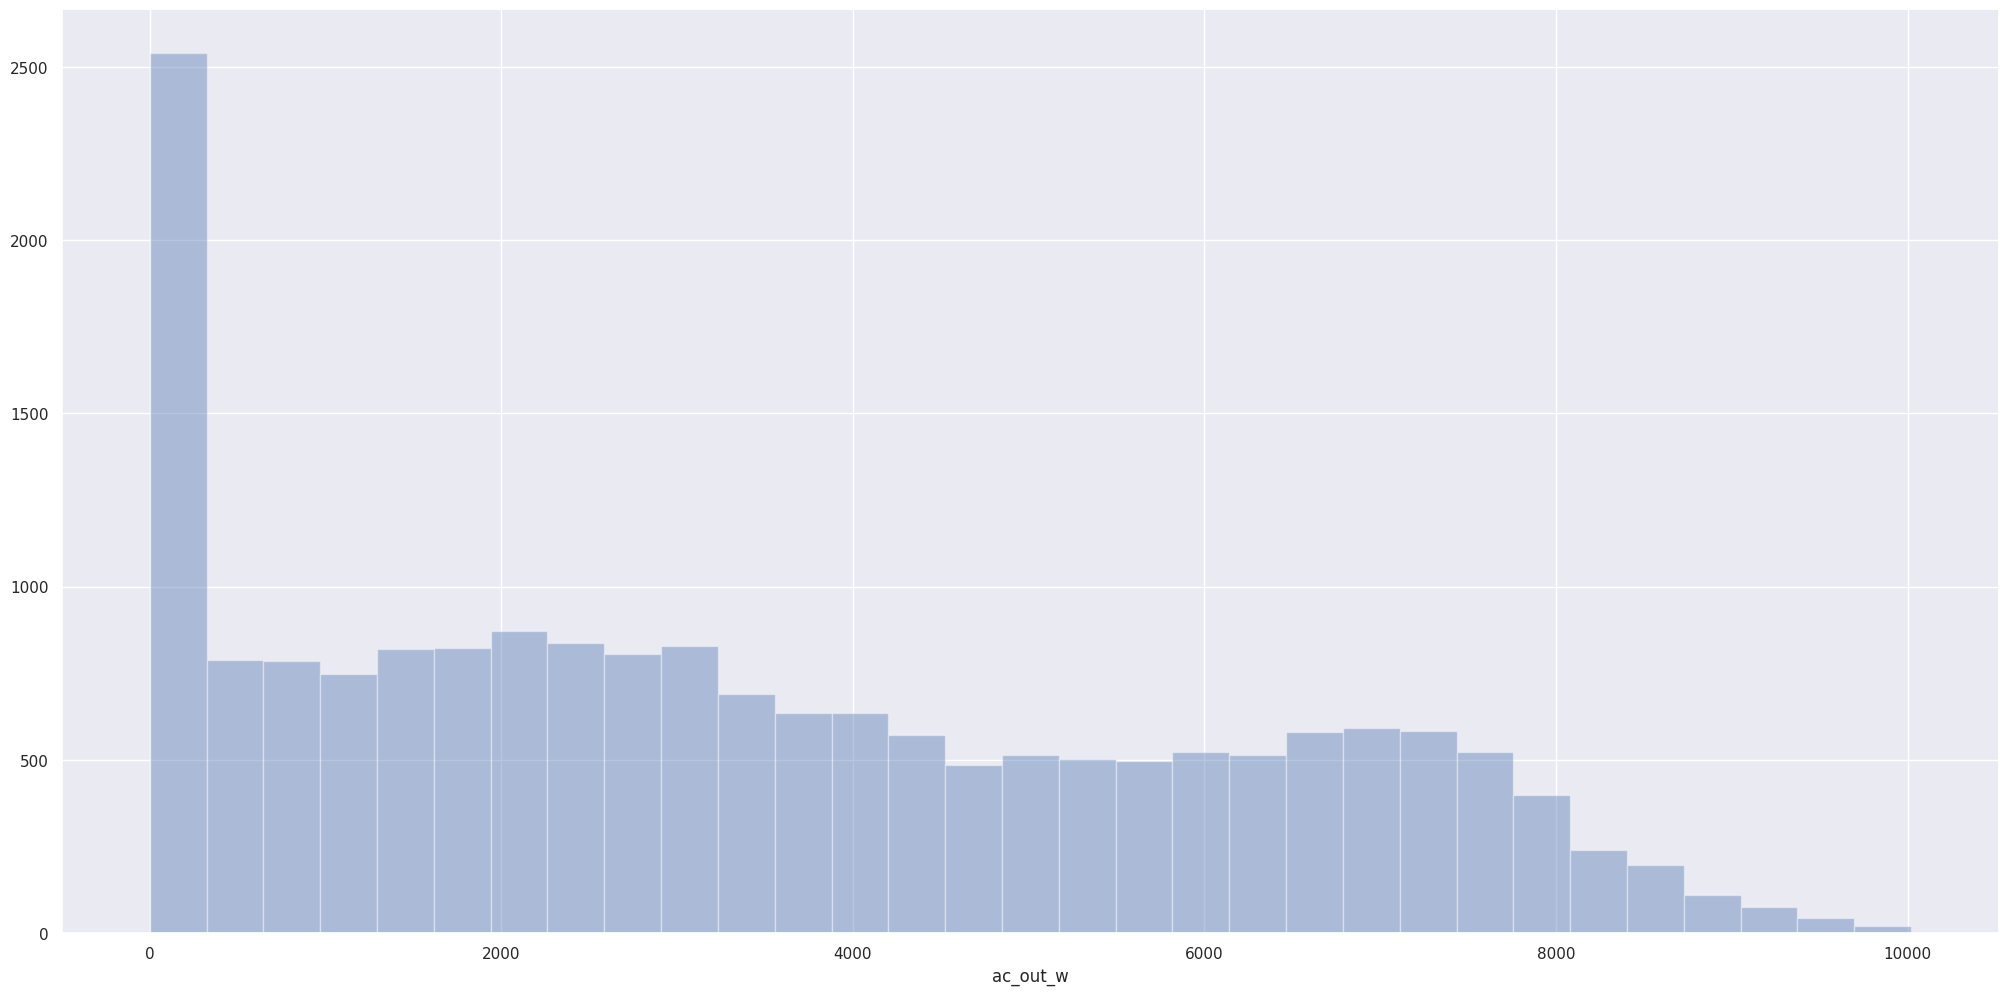

In [ ]:
sns.distplot(df_41['ac_out_w'], kde=False);

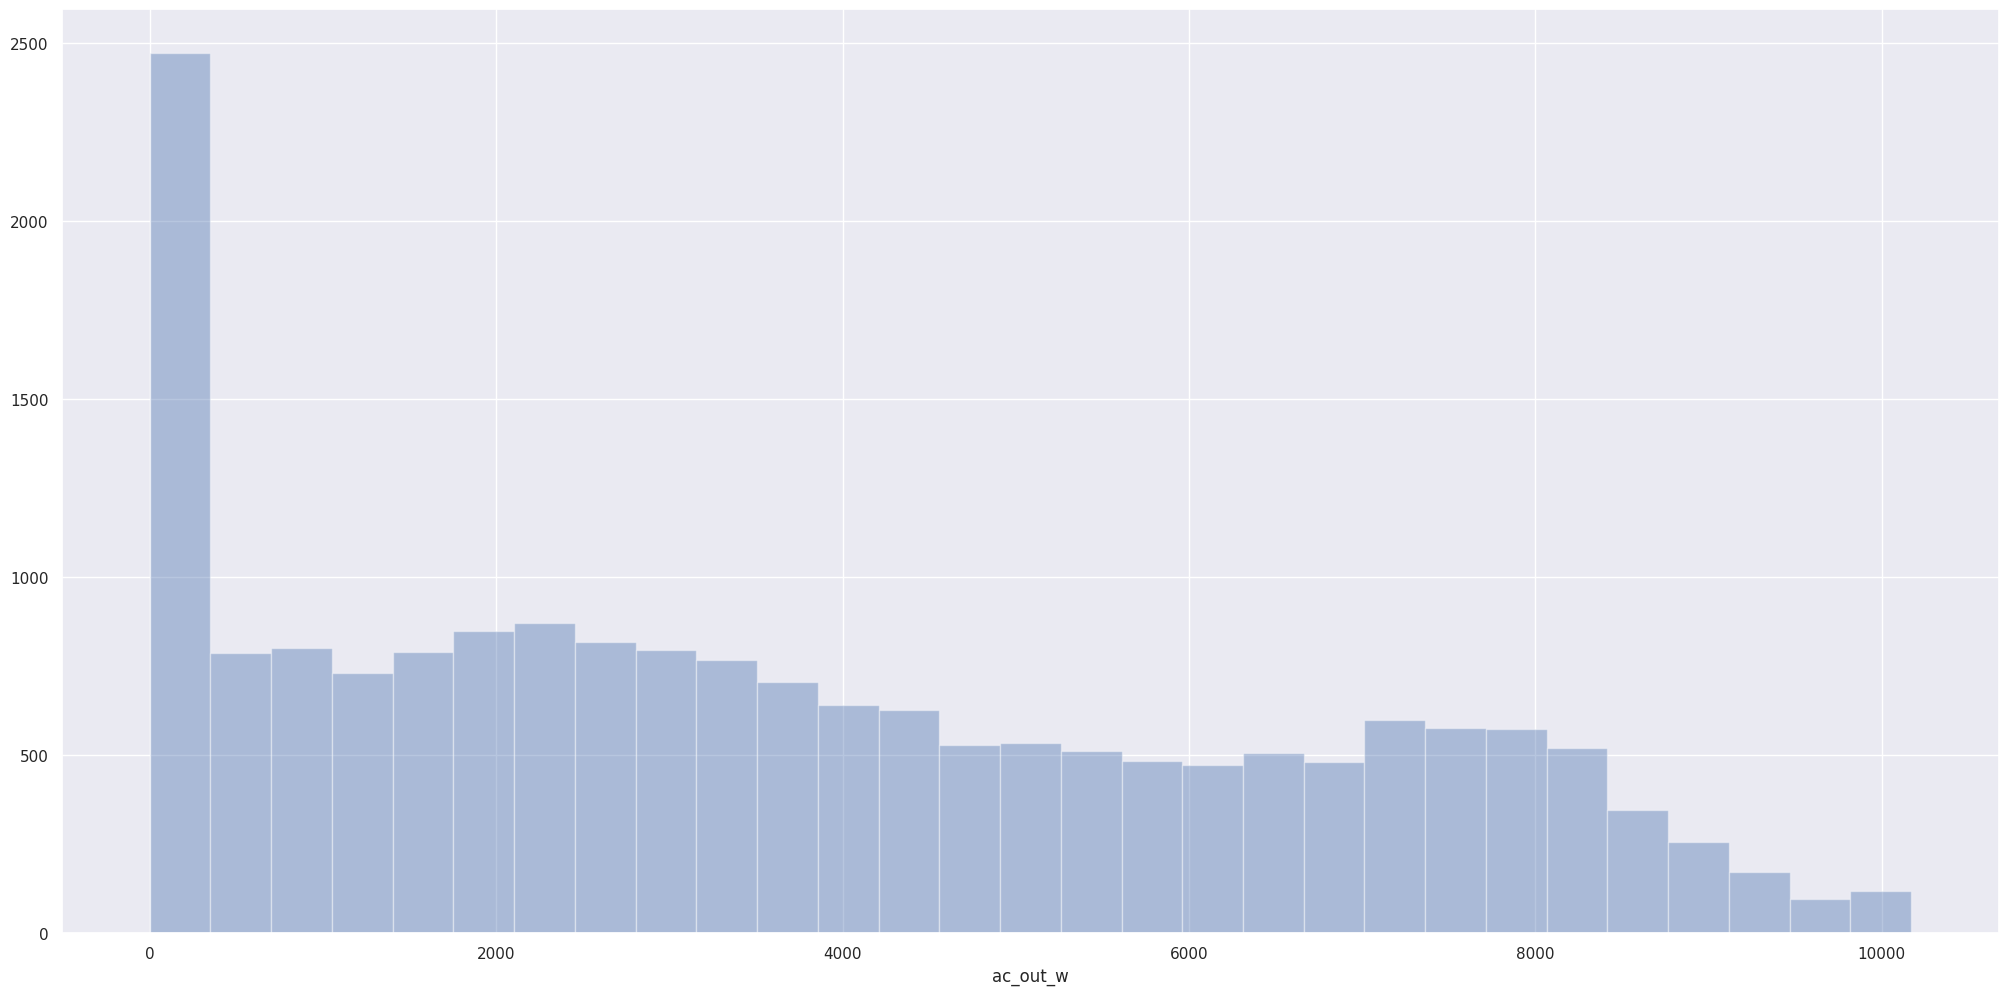

In [ ]:
sns.distplot(df_42['ac_out_w'], kde=False);

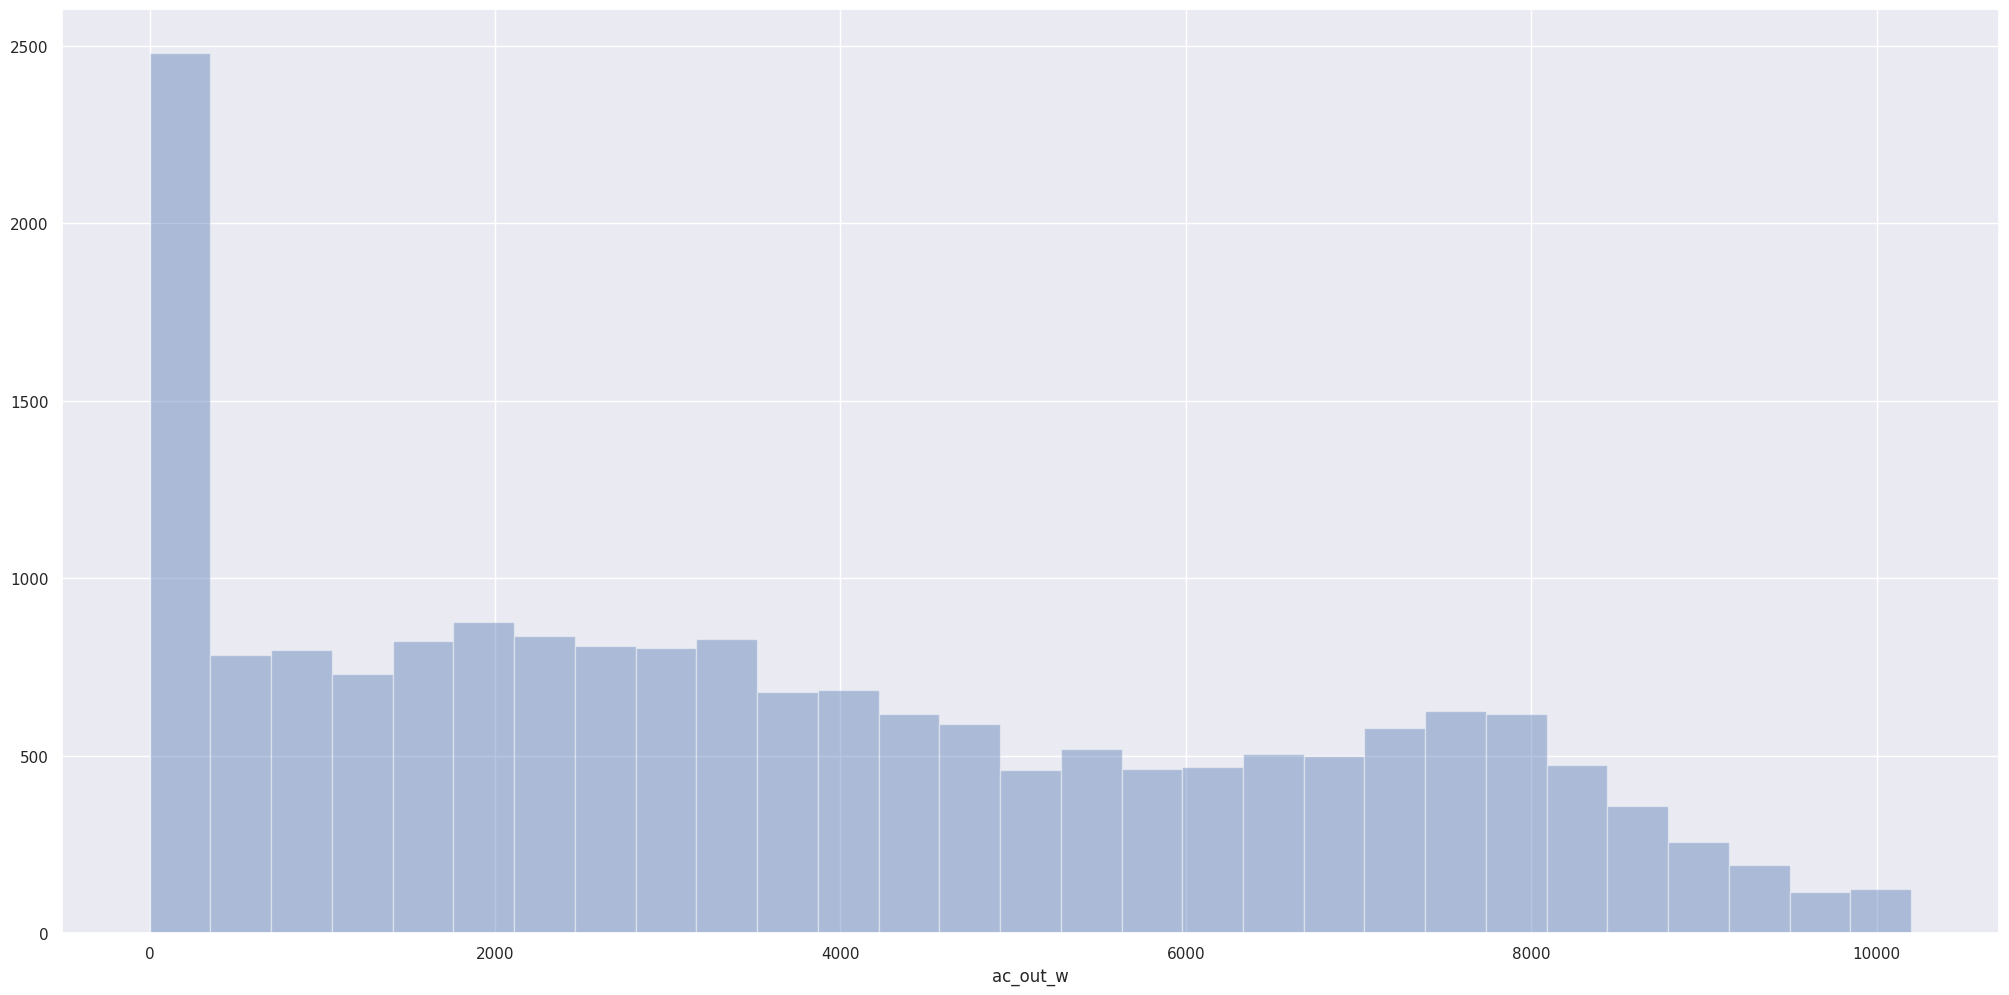

In [ ]:
sns.distplot(df_44['ac_out_w'], kde=False);

### 4.1.2 Numerical Variable

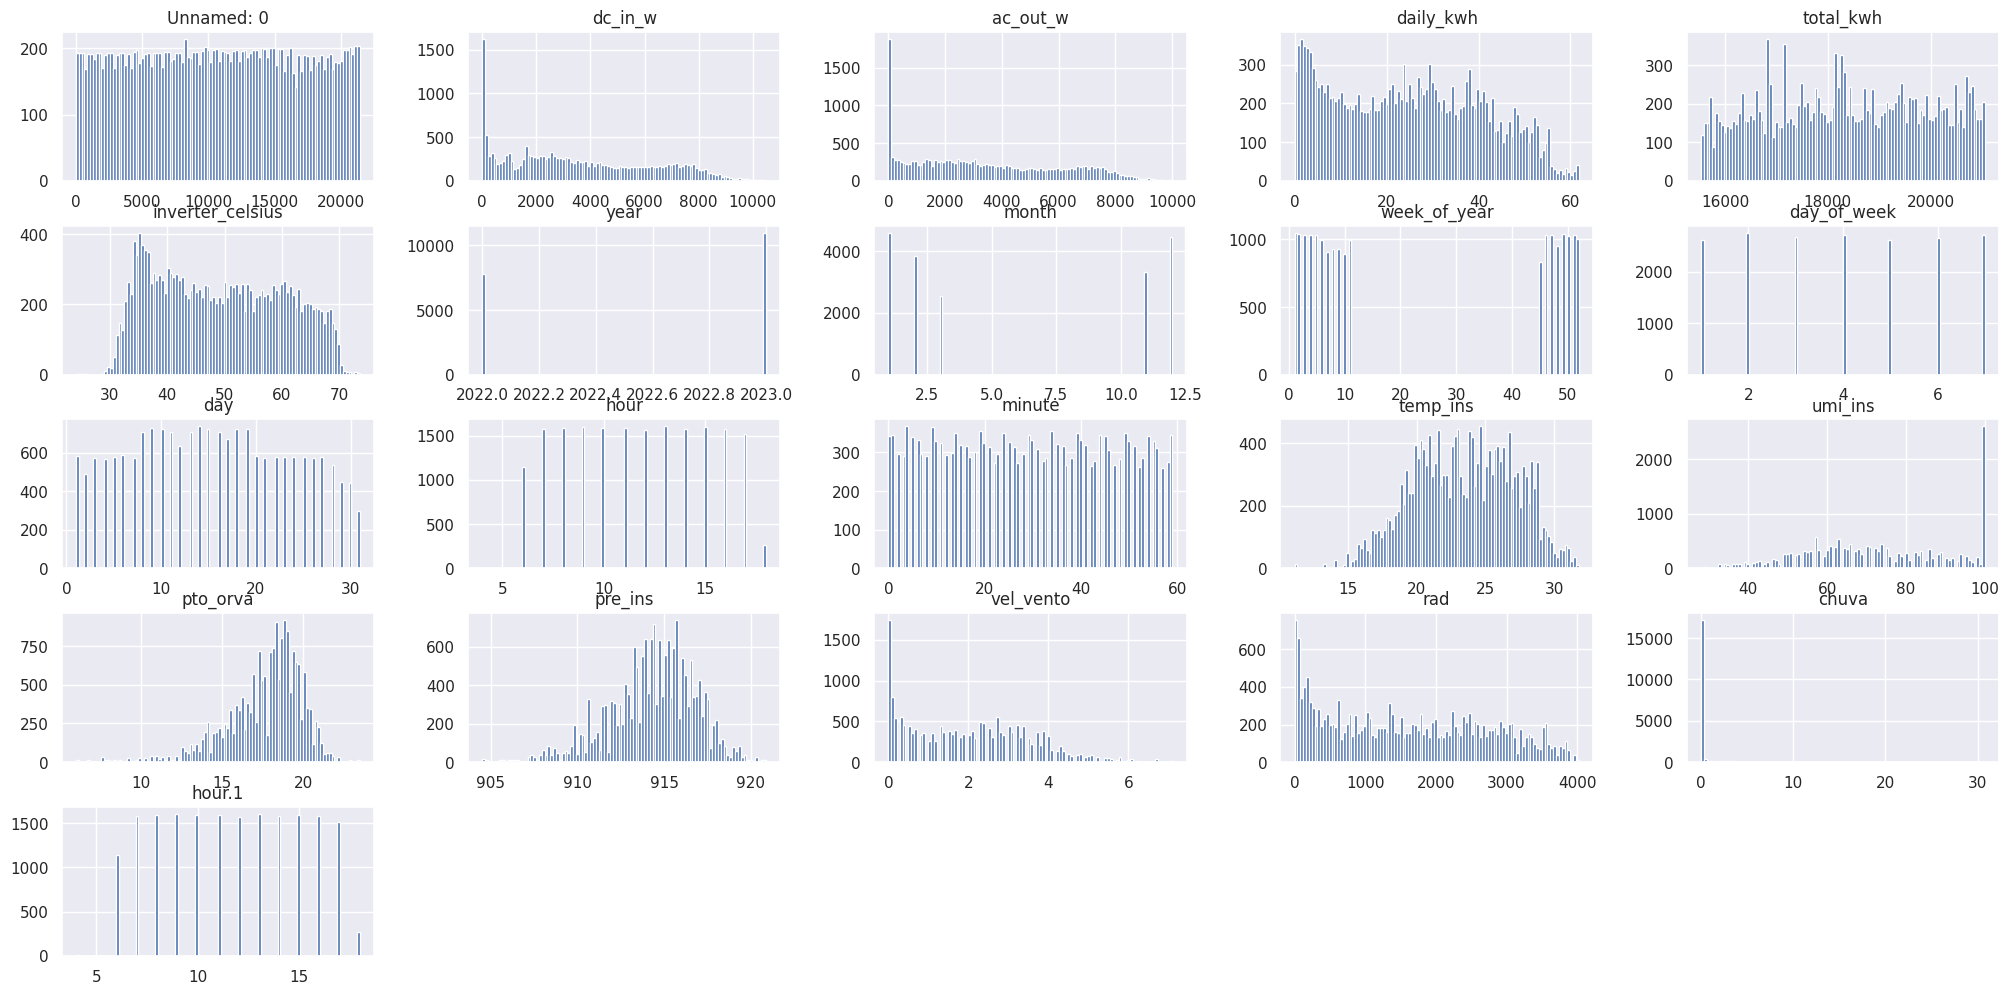

In [ ]:
num_attributes = df_41.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins=100);

In [ ]:
df_41.dtypes

Unnamed: 0            int64
time                 object
id                   object
dc_in_w               int64
ac_out_w              int64
daily_kwh           float64
total_kwh           float64
inverter_celsius    float64
date                 object
year                  int64
month                 int64
week_of_year          int64
day_of_week           int64
day                   int64
hour                  int64
minute                int64
temp_ins            float64
umi_ins             float64
pto_orva            float64
pre_ins             float64
vel_vento           float64
rad                 float64
chuva               float64
hour.1                int64
date.1               object
dtype: object

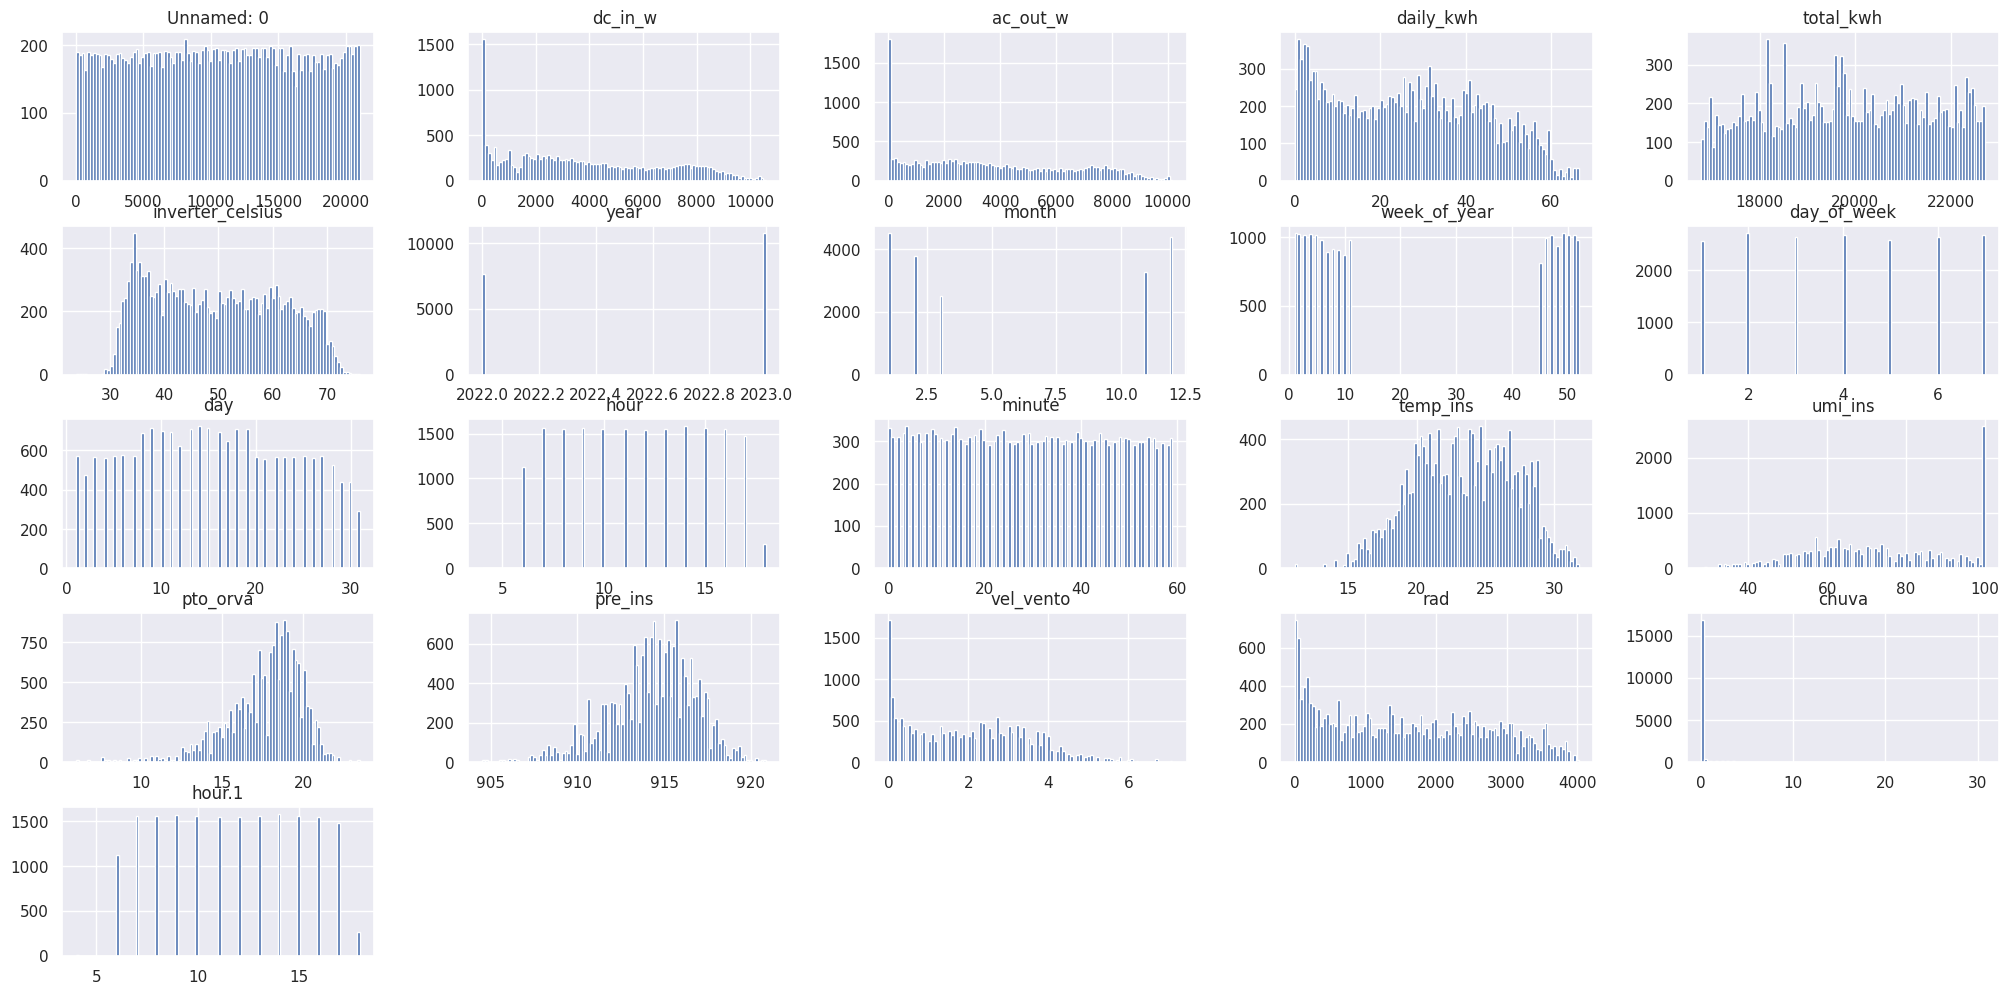

In [ ]:
num_attributes = df_42.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins=100);

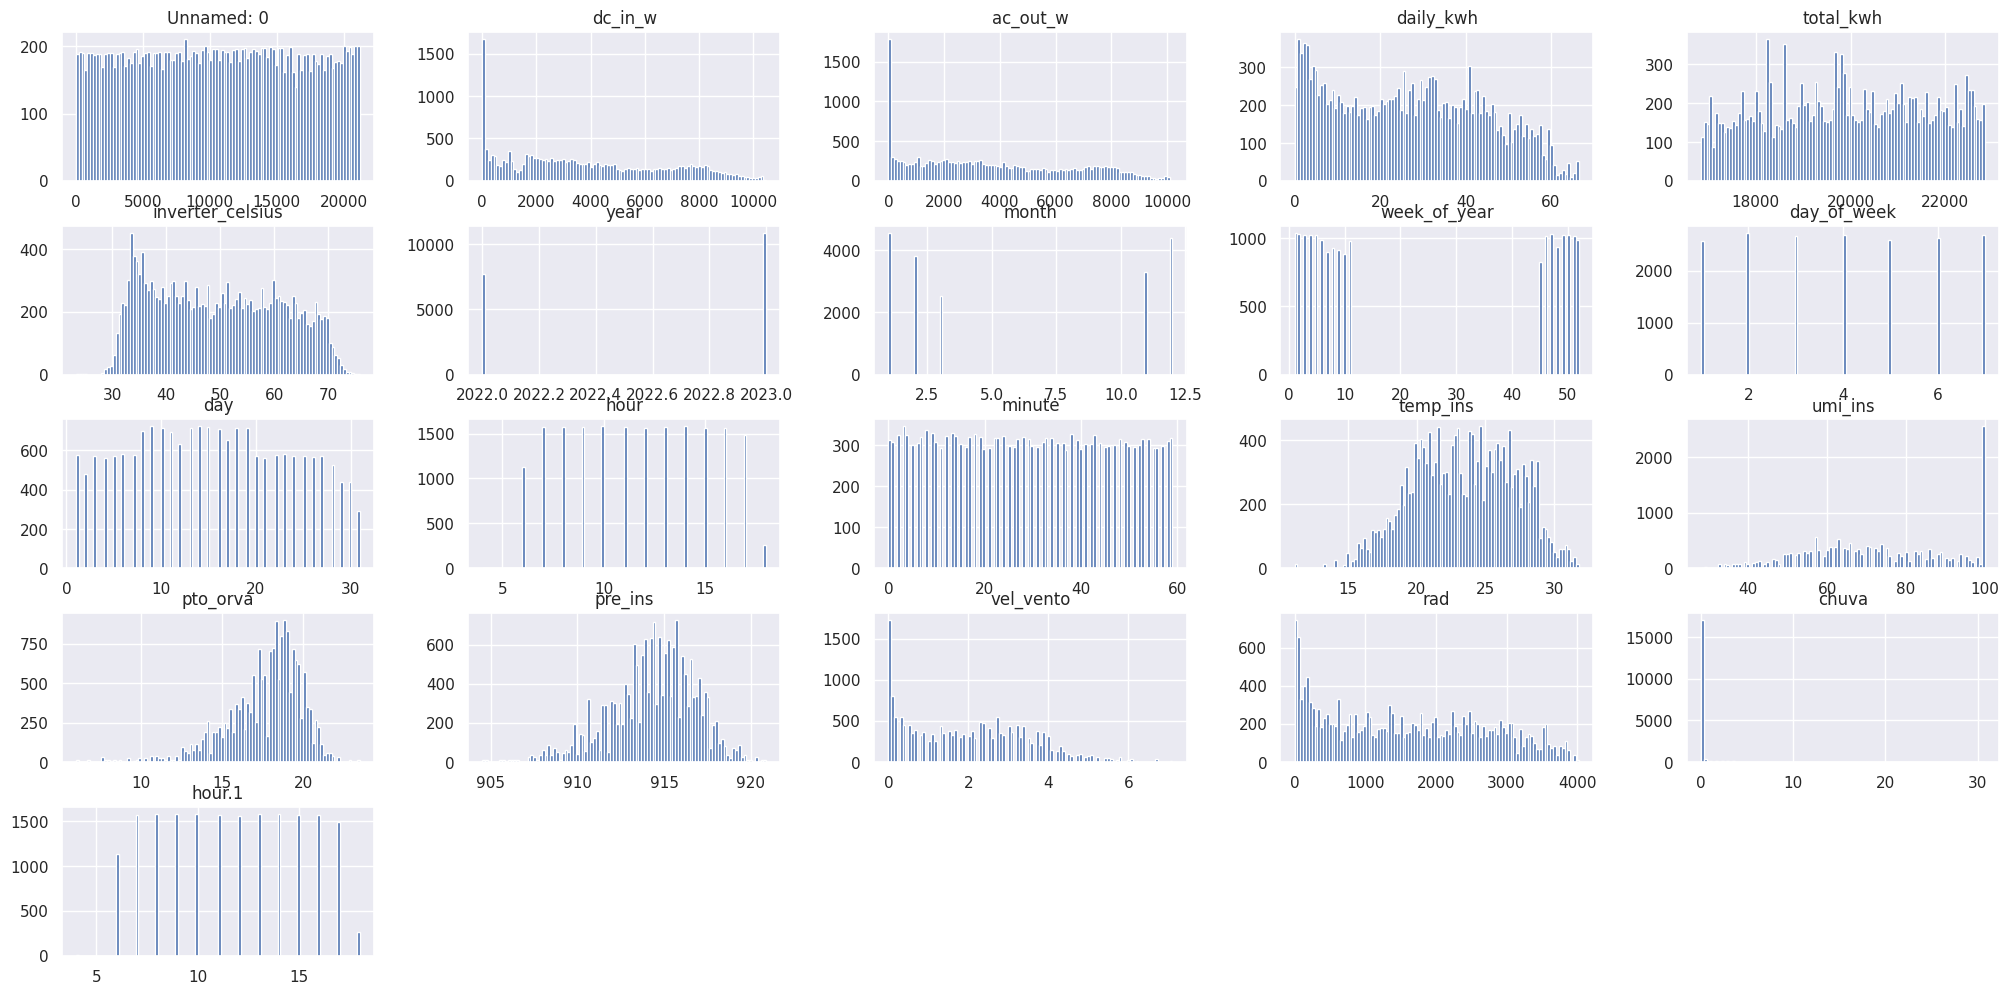

In [ ]:
num_attributes = df_44.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins=100);

# 5.0 DATA PREPARATION

## 5.1 Split dataframe into training and test dataset

In [ ]:
# training dataset
df_41_train = df_41[df_41['time'] < '2023-03-13']
df_42_train = df_42[df_42['time'] < '2023-03-13']
df_44_train = df_44[df_44['time'] < '2023-03-13']

# test dataset
df_41_test = df_41[df_41['time'] >= '2023-03-13 ']
df_42_test = df_42[df_42['time'] >= '2023-03-13 ']
df_44_test = df_44[df_44['time'] >= '2023-03-13 ']

print('Training Min Date: {}'. format(df_41_train['time'].min()))
print('Training Max Date: {}'. format(df_41_train['time'].max()))

print('\nTest Date Min Date: {}'. format(df_41_test['time'].min()))
print('Test Max Date: {}'. format(df_41_test['time'].max()))

Training Min Date: 2022-11-08 06:01:00
Training Max Date: 2023-03-12 16:51:00

Test Date Min Date: 2023-03-13 07:04:00
Test Max Date: 2023-03-19 18:38:00


## 5.2 Standardization

In [ ]:
ss = pp.StandardScaler()

## 5.3 Rescaling

In [ ]:
mms = pp.MinMaxScaler()

In [ ]:
def RescalingMMS(df):
    df['ac_out_w'] = mms.fit_transform(df[['ac_out_w']].values)
    #fig = plt.subplots(figsize = (15,5))
    #sns.histplot(df[['ac_out_w']].values, bins = 70);
    df['dc_in_w'] = mms.fit_transform(df[['dc_in_w']].values)
    df['daily_kwh'] = mms.fit_transform(df[['daily_kwh']].values)
    df['total_kwh'] = mms.fit_transform(df[['total_kwh']].values)
    df['inverter_celsius'] = mms.fit_transform(df[['inverter_celsius']].values)

In [ ]:
RescalingMMS(df_41_train)
RescalingMMS(df_41_test)
RescalingMMS(df_42_train)
RescalingMMS(df_42_test)
RescalingMMS(df_44_train)
RescalingMMS(df_44_test)

## 5.4 Nature Transformation

### 5.4.1 Training

In [ ]:
df_41_train['month_sin'] = df_41_train['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_41_train['month_cos'] = df_41_train['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_41_train['week_of_year_sin'] = df_41_train['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_41_train['week_of_year_cos'] = df_41_train['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_41_train['day_of_week_sin'] = df_41_train['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_41_train['day_of_week_cos'] = df_41_train['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_41_train['day_sin'] = df_41_train['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_41_train['day_cos'] = df_41_train['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_41_train['hour_sin'] = df_41_train['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_41_train['hour_cos'] = df_41_train['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_41_train['minute_sin'] = df_41_train['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_41_train['minute_cos'] = df_41_train['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_41_train = df_41_train.drop(cols_drop, axis = 1)

In [ ]:
df_42_train['month_sin'] = df_42_train['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_42_train['month_cos'] = df_42_train['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_42_train['week_of_year_sin'] = df_42_train['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_42_train['week_of_year_cos'] = df_42_train['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_42_train['day_of_week_sin'] = df_42_train['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_42_train['day_of_week_cos'] = df_42_train['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_42_train['day_sin'] = df_42_train['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_42_train['day_cos'] = df_42_train['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_42_train['hour_sin'] = df_42_train['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_42_train['hour_cos'] = df_42_train['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_42_train['minute_sin'] = df_42_train['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_42_train['minute_cos'] = df_42_train['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_42_train = df_42_train.drop(cols_drop, axis = 1)

In [ ]:
df_44_train['month_sin'] = df_44_train['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_44_train['month_cos'] = df_44_train['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_44_train['week_of_year_sin'] = df_44_train['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_44_train['week_of_year_cos'] = df_44_train['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_44_train['day_of_week_sin'] = df_44_train['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_44_train['day_of_week_cos'] = df_44_train['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_44_train['day_sin'] = df_44_train['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_44_train['day_cos'] = df_44_train['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_44_train['hour_sin'] = df_44_train['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_44_train['hour_cos'] = df_44_train['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_44_train['minute_sin'] = df_44_train['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_44_train['minute_cos'] = df_44_train['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_44_train = df_44_train.drop(cols_drop, axis = 1)

### 5.4.2 Test

In [ ]:
df_41_test['month_sin'] = df_41_test['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_41_test['month_cos'] = df_41_test['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_41_test['week_of_year_sin'] = df_41_test['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_41_test['week_of_year_cos'] = df_41_test['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_41_test['day_of_week_sin'] = df_41_test['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_41_test['day_of_week_cos'] = df_41_test['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_41_test['day_sin'] = df_41_test['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_41_test['day_cos'] = df_41_test['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_41_test['hour_sin'] = df_41_test['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_41_test['hour_cos'] = df_41_test['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_41_test['minute_sin'] = df_41_test['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_41_test['minute_cos'] = df_41_test['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_41_test = df_41_test.drop(cols_drop, axis = 1)

In [ ]:
df_42_test['month_sin'] = df_42_test['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_42_test['month_cos'] = df_42_test['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_42_test['week_of_year_sin'] = df_42_test['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_42_test['week_of_year_cos'] = df_42_test['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_42_test['day_of_week_sin'] = df_42_test['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_42_test['day_of_week_cos'] = df_42_test['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_42_test['day_sin'] = df_42_test['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_42_test['day_cos'] = df_42_test['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_42_test['hour_sin'] = df_42_test['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_42_test['hour_cos'] = df_42_test['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_42_test['minute_sin'] = df_42_test['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_42_test['minute_cos'] = df_42_test['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_42_test = df_42_test.drop(cols_drop, axis = 1)

In [ ]:
df_44_test['month_sin'] = df_44_test['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df_44_test['month_cos'] = df_44_test['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df_44_test['week_of_year_sin'] = df_44_test['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df_44_test['week_of_year_cos'] = df_44_test['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df_44_test['day_of_week_sin'] = df_44_test['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df_44_test['day_of_week_cos'] = df_44_test['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df_44_test['day_sin'] = df_44_test['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df_44_test['day_cos'] = df_44_test['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df_44_test['hour_sin'] = df_44_test['hour'].apply(lambda x: np.sin(x * (2 * np.pi/24)))
df_44_test['hour_cos'] = df_44_test['hour'].apply(lambda x: np.cos(x * (2 * np.pi/24)))

df_44_test['minute_sin'] = df_44_test['minute'].apply(lambda x: np.sin(x * (2 * np.pi/60)))
df_44_test['minute_cos'] = df_44_test['minute'].apply(lambda x: np.cos(x * (2 * np.pi/60)))

cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'hour', 'minute']
df_44_test = df_44_test.drop(cols_drop, axis = 1)

# 6.0 FEATURE SELECTION

## 6.1 Feature Selection df41

### 6.1.1 Target variable

In [ ]:
# training dataset
y_train_41 = df_41_train['ac_out_w']

# test dataset
y_test_41 = df_41_test['ac_out_w']

In [ ]:
df_41_train.columns

Index(['Unnamed: 0', 'time', 'id', 'dc_in_w', 'ac_out_w', 'daily_kwh',
       'total_kwh', 'inverter_celsius', 'date', 'year', 'temp_ins', 'umi_ins',
       'pto_orva', 'pre_ins', 'vel_vento', 'rad', 'chuva', 'hour.1', 'date.1',
       'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos',
       'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos'],
      dtype='object')

### 6.1.2 Boruta as Feature Selector

In [ ]:
# training and test dataset for Boruta
X_train_n_41 = df_41_train.drop(['id', 'time', 'date', 'date.1', 'ac_out_w', 'dc_in_w', 'daily_kwh', 'total_kwh', 'inverter_celsius'], axis = 1).values
y_train_n_41 = y_train_41.values.ravel() # ravel is to vetorize the values

In [ ]:
# define randomforestregressor
rf = RandomForestRegressor(n_jobs = -1)

In [ ]:
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n_41, y_train_n_41)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	9
I

### 6.2.1 Best Features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs_41 = df_41_train.drop(['id', 'time', 'date', 'date.1', 'ac_out_w', 'dc_in_w', 'daily_kwh', 'total_kwh', 'inverter_celsius'], axis = 1) 

In [ ]:
cols_selected_boruta = X_train_fs_41.iloc[:, cols_selected].columns.to_list()

In [ ]:
cols_selected_boruta

['Unnamed: 0',
 'temp_ins',
 'umi_ins',
 'pto_orva',
 'pre_ins',
 'vel_vento',
 'rad',
 'hour.1',
 'day_sin',
 'day_cos',
 'hour_sin',
 'minute_sin']

# 7.0 MACHINE LEARNING MODELING

In [ ]:
# initially without date and sales
x_train_41 = df_41_train[cols_selected_boruta]
x_test_41  = df_41_test[cols_selected_boruta]

x_train_42 = df_42_train[cols_selected_boruta]
x_test_42  = df_42_test[cols_selected_boruta]

## 7.1 Random Forest Regressor 41

In [ ]:
rf_41 = RandomForestRegressor(n_estimators = 25, n_jobs = -1, random_state = 42).fit(x_train_41, y_train_41)

In [ ]:
# prediction
yhat_rf_41 = rf_41.predict(x_test_41)

In [ ]:
# performance
rf_result_41 = ml_error('Random forest Regressor', np.expm1(y_test_41), np.expm1(yhat_rf_41))
rf_result_41

,Model Name,MAE,MAPE,RMSE
0,Random forest Regressor,0.287006,4.312914e+12,0.381707


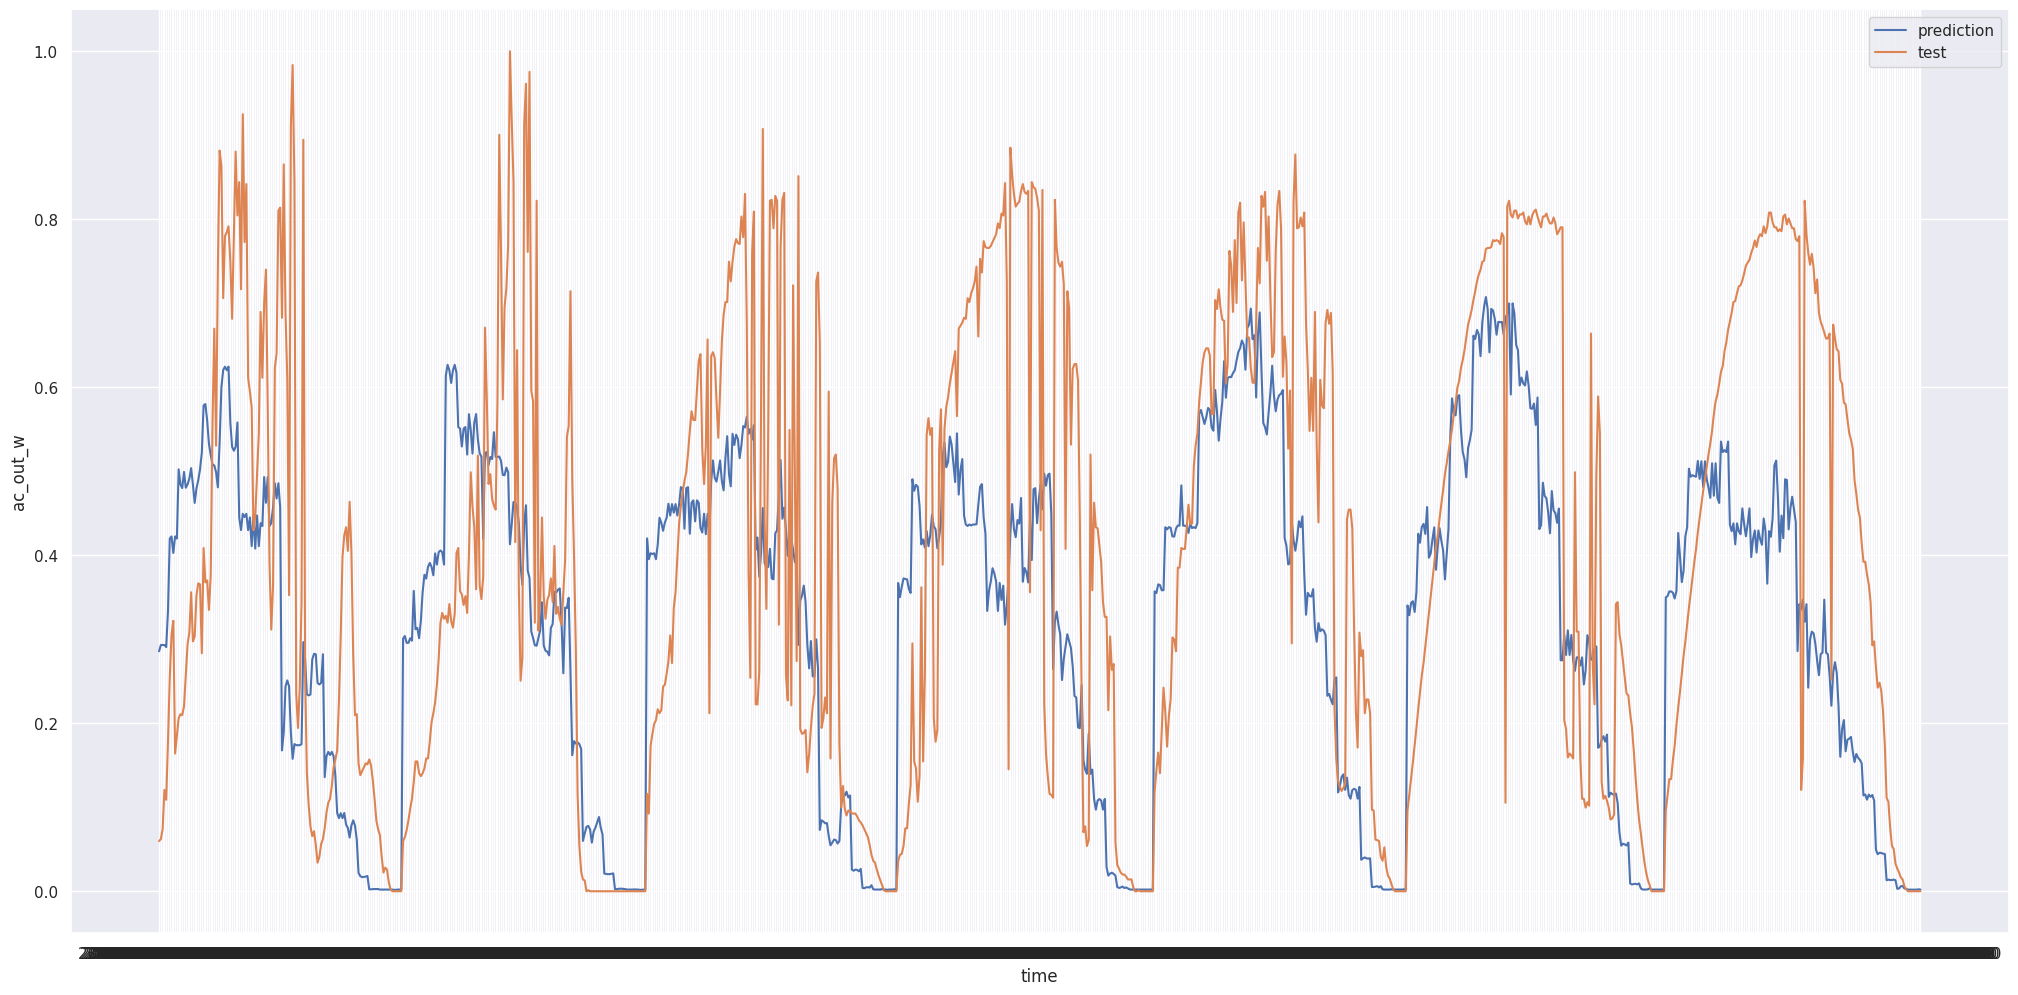

In [ ]:
sns.lineplot(x = df_41_test['time'], y = yhat_rf_41, label = 'prediction')
sns.lineplot(x = df_41_test['time'], y = y_test_41, label = 'test');

## 7.2 Random Forest Regressor 42

In [ ]:
rf_42 = RandomForestRegressor(n_estimators = 25, n_jobs = -1, random_state = 42).fit(x_train_41, y_train_41)

In [ ]:
# prediction
yhat_rf_42 = rf_42.predict(x_test_42)

In [ ]:
# performance
y_test_42 = df_42_test['ac_out_w']

rf_result_42 = ml_error('Random forest Regressor', np.expm1(y_test_42), np.expm1(yhat_rf_42))
rf_result_42

,Model Name,MAE,MAPE,RMSE
0,Random forest Regressor,0.254259,9.172475e+09,0.338304


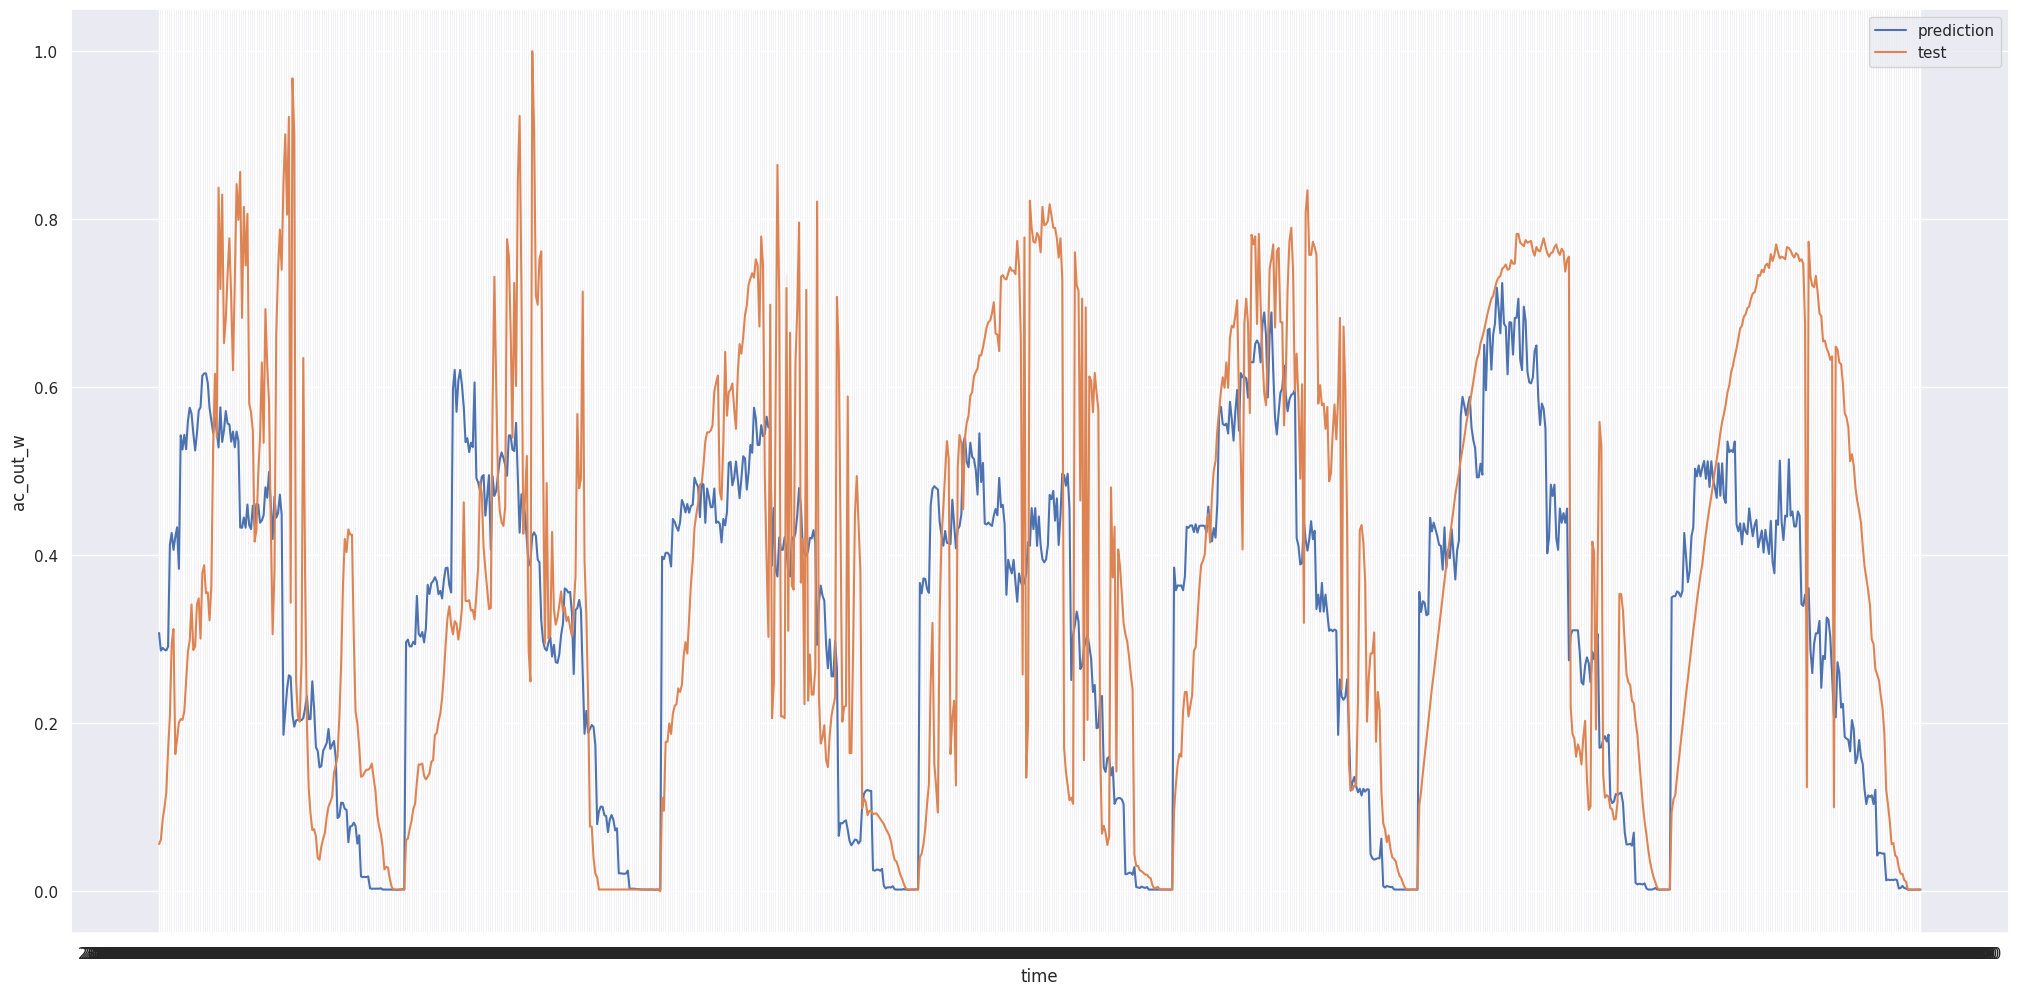

In [ ]:
sns.lineplot(x = df_42_test['time'], y = yhat_rf_42, label = 'prediction')
sns.lineplot(x = df_42_test['time'], y = y_test_42, label = 'test');